# Tutorial 6.2.2.Turbulence Synthesis Inlet for Large Eddy Simulation

Project: Structural Wind Engineering WS20-21 
        Chair of Structural Analysis @ TUM - R. Wüchner, M. Péntek, A. Kodakkal

Author: Ammar Khallouf

Created on:  24.11.2020

Last Update: 15.12.2020

####  Content:

A random flow generation (RFG) technique is implemented here on the basis of the work by **_Smirnov et al.(2001)_.** and **_Kraichnan (1970)_.** 

According to the authors. The method can generate an isotropic divergence-free fluctuating velocity field satisfying the Gaussian's spectral model as well as an inhomogeneous and anisotropic turbulence flow, provided that an anisotropic velocity correlation tensor is given.

The transient  flow field is generated as a superposition of harmonic functions with random coefficients. 

The approach is used to set inlet boundary conditions to LES models as well as initial boundary conditions in the simulation of turbulent flow around bluff-bodies.

####  Input:


The input of this procedure are the mean speed at the inlet:  ${u_{avg}}$ ,turbulent intensities: ${I_u}$ , ${I_v}$ , ${I_w}$
and turbulent length scale: ${L}$





####  References:
[1] _S. S. A. Smirnov and I. Celik, Random flow generation technique for large eddy simulations and particle-dynamics modeling, Journal of Fluids Engineering,123 (2001), pp. 359-371._

[2] _R. Kraichnan, Diffusion by a random velocity field, The Physics of Fluids, 13(1970), pp. 22-31._



In [1]:
# Import of some python modules and vector normal random generator.
import numpy as np
import time
import sys
import math
from pylab import *
import random
from IPython.core.display import display, Math
from scipy import signal
from matplotlib import pyplot as plt


#### 1. Read Input mean velocity, turbulent intensities and length scale 

In [2]:
# u_avg -> mean longitudinal (y axis) wind speed, per node, [m/s]:
u_avg = 23.6

#turbulence intensity Iu != Iv != Iw
Iu = 0.1
Iv = 0.1
Iw = 0.1
urms = u_avg*Iu
vrms = u_avg*Iv
wrms = u_avg*Iw

#L -> turbulence length scale [m]
Lu = Lv = Lw = 0.1
Ls = math.sqrt(Lu**2 + Lv**2 + Lw**2)

# function to generate random vectors:
def normalrandomvec(mean,sigma):
    x=random.gauss(mean,sigma)
    y=random.gauss(mean,sigma)
    z=random.gauss(mean,sigma)
    return np.array([x,y,z]) # 1x3

#### 2. Given an anisotropic velocity correlation tensor $r_{i j}=\overline{\tilde{u}_{i} \tilde{u}_{j}}$ of a turbulent flow field $\tilde{u}_{i}\left(x_{j}, t\right)$.

#### We find an orthogonal transformation tensor $a_{i j}$ that diagonalizes $r_{i j}$:

$$a_{m i} a_{n j} r_{i j}=c_{(n)}^{2} \delta_{m n}
$$

$$a_{m i} a_{n j}=\delta_{i j}
$$

As a result of this step both $a_{i j}$ and $c_{(n)}$ become known functions of space. 

Coefficients $c_{n}=\left\{c_{1}, c_{2}, c_{3}\right\}$ play the role of turbulent fluctuating velocities $\left(u^{\prime}, v^{\prime}, w^{\prime}\right)$ in the new coordinate system produced by transformation tensor $a_{i j}$ 

In [3]:
# construct anisotropic velocity correlation tensor:
rij = np.array([[urms**2, 0, 0],[0, vrms**2, 0],[0, 0, wrms**2]])

#find an orthogonal transformation tensor aij that would diagonalize rij:
aij, c2 = np.linalg.eig(rij)
cn = np.sqrt([aij[0], aij[1], aij[2]]) # 1x3

#N -> sampling number for each wavenumber kn
N = 1000

# x -> nodal coordinates
x = np.array([[0.0],[0.0],[0.0]]) # 3x1
timev = np.arange(0,3.,0.0001) # 4000,

#### 3. Generate a transient turbulent velocity field in 3D using a modifcation of the Kraichnan method  _(Kraichnan,1970)_

$$v_{i}(x, t)=\sqrt{\frac{2}{N}} \sum_{n=1}^{N}\left[p_{i}^{n} \cos \left(\tilde{k}_{j}^{n} \tilde{x}_{j}+\omega_{n} \tilde{t}\right)+q_{i}^{n} \sin \left(\tilde{k}_{j}^{n} \tilde{x}_{j}+\omega_{n} \tilde{t}\right)\right]
$$

#### Where:

$$
\tilde{x}=\frac{x}{l}, \quad \tilde{t}=\frac{t}{\tau}, \quad \tilde{k}_{j}^{n}=k_{j}^{n} \frac{c}{c_{(j)}}, \quad c=\frac{l}{\tau}
$$

$$
p_{i}^{n}=\epsilon_{i j m} \zeta_{j}^{n} k_{m}^{n}, \quad q_{i}^{n}=\epsilon_{i j m} \xi_{j}^{n} k_{m}^{n}
$$

$$
\zeta_{i}^{n}, \xi_{i}^{n}, \omega_{n} \in N(0,1) ; \quad k_{i}^{n} \in N(0,1 / 2)
$$

Where: 
$l, \tau$ are the length and time scales of turbulence, $\epsilon_{i j m}$ is the permutation
tensor and $N(M, \sigma)$ is a normal distribution with mean $M$ and standard deviation $\sigma$. $k_{i}^{n}$
and $\omega_{n}$ represent a sample of $n$ wavenumber vectors and frequencies
of the theoretical modeled turbulence spectrum:

$$
E(k)=16\left(\frac{2}{\pi}\right)^{1 / 2} k^{4} \exp \left(-2 k^{2}\right)
$$

In [4]:
print ("begin simulation...")

#modified Kraichnan's method

uxt = np.zeros([3,timev.size]) # 3x4000
pni = np.zeros([3,1]) # 3x1
qni = np.zeros([3,1]) # 3x1
knjtil = np.zeros([3,1]) # 3x1

#time-scale of turbulence [sec]

tau = Ls/u_avg
timetil = timev/tau # 4000,
xtil = x/Ls # 3x1
c = Ls/tau
un = np.zeros([3,timev.size]) # 3x4000

# initialize seed:
random.seed()
for n in range(0,N):
    
    omegamn = random.gauss(0,1)
    knj = normalrandomvec(0,0.5) # 1x3
    Zetan = normalrandomvec(0,1) # 1x3
    Xin = normalrandomvec(0,1) # 1x3
    pni = np.cross(Zetan.transpose(),knj.transpose()) # 1x3
    qni = np.cross(Xin.transpose(),knj.transpose()) # 1x3
    knjtil[0,0] = knj[0]*c/cn[0]
    knjtil[1,0] = knj[1]*c/cn[1]
    knjtil[2,0] = knj[2]*c/cn[2]
    
    un[0,:] = un[0,:] + \
            + pni[0]*cos(np.inner(knjtil.T,xtil.T) + omegamn*timetil[:]) + \
            + qni[0]*sin(np.inner(knjtil.T,xtil.T) + omegamn*timetil[:]) \
    
    un[1,:] = un[1,:] + \
    + pni[1]*cos(np.inner(knjtil.T,xtil.T) + omegamn*timetil[:]) + \
    + qni[1]*sin(np.inner(knjtil.T,xtil.T) + omegamn*timetil[:]) \
    
    un[2,:] = un[2,:] + \
            + pni[2]*cos(np.inner(knjtil.T,xtil.T) + omegamn*timetil[:]) + \
            + qni[2]*sin(np.inner(knjtil.T,xtil.T) + omegamn*timetil[:]) \
    
    uxt[0,:] = cn[0]*math.sqrt(2./N)*un[0,:]
    uxt[1,:] = cn[1]*math.sqrt(2./N)*un[1,:]
    uxt[2,:] = cn[2]*math.sqrt(2./N)*un[2,:]

print ("end simulation...")

begin simulation...
end simulation...


#### 4. Scale and transform the velocity field  $v_{i}$  generated in the previous step to obtain the turbulent flow field $u_{i}$
$$
\begin{array}{c}
w_{i}=c_{i} v_{i} \\
u_{i}=a_{i k} w_{k}
\end{array}
$$

The plots below show the turbulent fluctuations in the velocity field with respect to  the average velocity $u_{avg}$

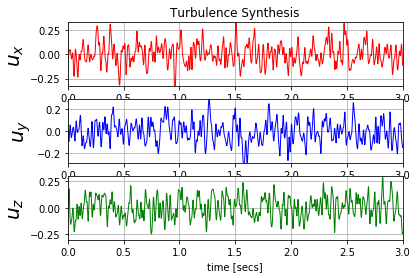

In [5]:
um = max(uxt[0,:])
vm = max(uxt[1,:])
wm = max(uxt[2,:])

subplot(311)
plot(timev,uxt[0,:]/u_avg,color="red",linewidth=1)
axis([0, 3, -um/u_avg, um/u_avg])
title('Turbulence Synthesis')
xlabel('time [secs]')
ylabel('$u_x$',fontsize=20)
grid(True)

subplot(312)
plot(timev,uxt[1,:]/u_avg,color="blue",linewidth=1)
axis([0, 3, -vm/u_avg, vm/u_avg])
xlabel('time [secs]')
ylabel('$u_y$',fontsize=20)
grid(True)
subplot(313)

plot(timev,uxt[2,:]/u_avg,color="green",linewidth=1)
axis([0, 3, -wm/u_avg, wm/u_avg])
xlabel('time [secs]')
ylabel('$u_z$', fontsize=20)
grid(True)

#### 5. Plot the energy spectrum on a log scale of simulated turbulence against the theoretical turbulence spectrum:

$$
E(k)=16\left(\frac{2}{\pi}\right)^{1 / 2} k^{4} \exp \left(-2 k^{2}\right)
$$

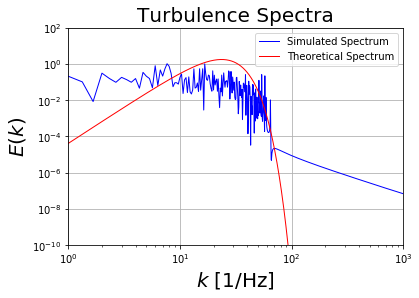

In [6]:
# simulated spectrum fluctuations

#fff,pf = signal.welch(uxt)
fff,pf = signal.periodogram(uxt,1/0.0001)

#plt.semilogx(fff,pf[2,:])

# theoretical spectrum fluctuations
kmax = 100
k = np.arange(0.1,kmax,0.5) # 400,

#k = f/u_avg

Ek = 16.*math.sqrt(2./math.pi)*(k/u_avg)**4.*(np.exp(-2.*(k/u_avg)**2.))

fig,ax = subplots()
ax.loglog(fff,pf[0,:],"b",linewidth=1)
ax.loglog(k,Ek,"r",linewidth=1)
ax.axis([1, 1000, 1.e-10, 100])
ax.set_xlabel('$k$ [1/Hz]',fontsize=20)
ax.set_ylabel('$E(k)$', fontsize=20)
ax.set_title('Turbulence Spectra', fontsize=20)
ax.legend(["Simulated Spectrum","Theoretical Spectrum"]);
ax.grid(True)
plt.rc('xtick',labelsize=12)
plt.rc('ytick',labelsize=12)

#### 6. Plot the 3D turbulent velocity field compoments as function of simulation time of 3 seconds

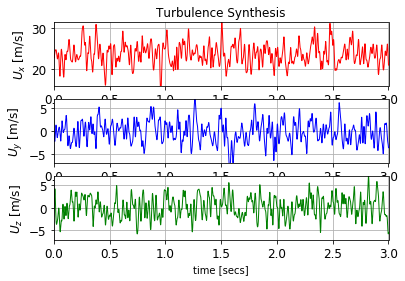

In [7]:
subplot(311)
plot(timev,u_avg+uxt[0,:],color="red",linewidth=1)
axis([0, 3, u_avg-um, u_avg+um])
title('Turbulence Synthesis')
xlabel('time [secs]')
ylabel('$U_x$ [m/s]',fontsize=12)
grid(True)


subplot(312)
plot(timev,uxt[1,:],color="blue",linewidth=1)
axis([0, 3, -vm, vm])
xlabel('time [secs]')
ylabel('$U_y$ [m/s]',fontsize=12)
grid(True)

subplot(313)
plot(timev,uxt[2,:],color="green",linewidth=1)
axis([0, 3, -wm, wm])
xlabel('time [secs]')
ylabel('$U_z$ [m/s]', fontsize=12)
grid(True)
